## Exploratory Data Analysis of Alzheimer's Deaths During the COVID-19 Pandemic

This Notebook explores the potential correlation between COVID-19 lockdowns and rises in Alzheimers deaths. According to News-Medical Science (2020), research indicates that social isolation worsens the effects of Alzheimer's disease according to a study. A second study by JAMA Psychiatry (2007) indicates that loneliness was associated with an increased risk of late-life dementia (the broader categroy that Alzheimer's falls under). Throughout the COVID-19 pandemic and particuarly among retirement communities and nursing homes, an increase in cases also corresponded with an increase in lockdowns and the quarantines of residents and medical staff when exposed to COVID-19. By examining data, I wanted to see if there was an increased correlation of Alzheimer's death rates when cases of COVID-19 were high due to the increased rates of isolation that often coincided with higher numbers of cases.

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests

I began by importing recent data from the CDC which gathers the number and causes of death by state in the United States after cleaning the data in a separate IDE and saving as a new file. I also merged two other tables to the main dataframe seen below including data on populations by state and the State Codes for better analysis. For source information, please view the README.md document.

In [166]:
# health and population data

alz_df = pd.read_csv('mortality_cleaned_data.csv')

alz_df['alz_per_capita'] = (alz_df['alzheimer'] / alz_df['Pop2021']) * 100000
alz_df['week'] = pd.to_datetime(alz_df['week'], format='%Y-%m-%d')
alz_df['date_accessed'] = pd.to_datetime(alz_df['date_accessed'])

alz_df.head(5)

,Unnamed: 0,rank,State,Pop,Growth,Pop2021,Pop2010,growthSince2010,Percent,density,...,lower_resp_distress,other_resp,nephritis,nephrotic_synd_and_nephrosis,other,heart_disease,cerebrovasc_disease,covid_19_multiple_cause,Code,alz_per_capita
0,0,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,86.0,13.0,25.0,25.0,268.0,81.0,0.0,0.0,AL,1.094404
1,1,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,72.0,20.0,23.0,34.0,274.0,68.0,0.0,0.0,AL,0.830936
2,2,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,73.0,21.0,23.0,24.0,239.0,45.0,0.0,0.0,AL,1.074137
3,3,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,61.0,11.0,14.0,23.0,284.0,70.0,0.0,0.0,AL,1.094404
4,4,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,76.0,17.0,20.0,23.0,265.0,55.0,0.0,0.0,AL,1.175471


Second, I imported information on COVID cases in the United States and used a simple .diff() function to access the daily case numbers. (Source information on README doc in GitHub)

In [167]:
# COVID-19 data

url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
covid_df = pd.read_csv(url, index_col=False)

covid_df['daily_cases'] = covid_df['cases'].diff()

covid_df.tail()

,date,cases,deaths,daily_cases
829,2022-04-29,81237905,991921,81658.0
830,2022-04-30,81260231,992010,22326.0
831,2022-05-01,81275599,992033,15368.0
832,2022-05-02,81371443,992424,95844.0
833,2022-05-03,81440777,993088,69334.0


Using the Folium library in Python, I created a cloropleth map to better visualize the highest rates of Alzheimer's deaths per capita (note: estimation per 100,000 is approximate) in the past 2 years. Interestingly, cases are particularly high in the neighboring states of Mississippi, Alabama, and Arkansas. 

In [173]:
# top 10 medians per capita by state

state_geo = f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
response = requests.get(state_geo)
geojson = response.json()

map_data = alz_df.groupby('Code', as_index = False)['alz_per_capita'].sum()

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=map_data,
    columns=["Code", "alz_per_capita"],
    key_on="feature.id",
    fill_color="GnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Alzheimer's Deaths (%)",
).add_to(m)

m

A bar chart shows the top states with the highest rates of Alzheimers, corresponding to the map above:

Text(0.5, 0, 'State')

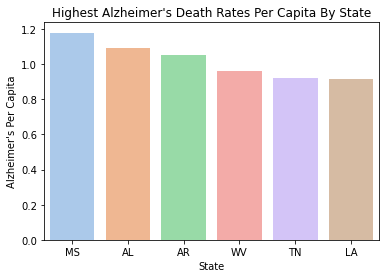

In [169]:
# top 6 max values per capita by state 
grouped_data = alz_df.groupby('Code')['alz_per_capita'].median().sort_values(ascending=False).reset_index()
largest_six = grouped_data.nlargest(6,'alz_per_capita')

ax = sns.barplot(x="Code", y="alz_per_capita", data=largest_six, palette='pastel')
ax.set_title('Highest Alzheimer\'s Death Rates Per Capita By State')
ax.set_ylabel('Alzheimer\'s Per Capita')
ax.set_xlabel('State')

A linegraph comparison of Alzheimer's deaths and covid cases shows a near direct correlation between rising cases and deaths. I hypothesize that the spikes in cases also brought along increased isolation whether this was from quarantine, distancing from loved ones, or staffing shortages due to increased levels of the virus. 

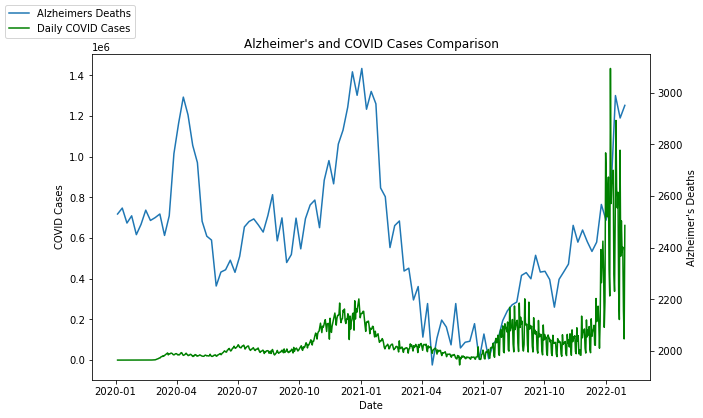

In [170]:
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax2=fig.add_subplot(111, frame_on=False)

total_before_2022 = alz_df.loc[(alz_df['week'] < '2-01-2022')]
total_before_2022 = alz_df.groupby(total_before_2022['week'])['alzheimer'].sum().reset_index()

ax.plot(total_before_2022['week'], total_before_2022['alzheimer'], label="Alzheimers Deaths")
ax.set_ylabel('Alzheimer\'s Deaths')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel('Date')

covid_before_2022 = covid_df.loc[(covid_df.date < '2022-02-01')]
ax2.plot(covid_before_2022['date'], covid_before_2022['daily_cases'], color='green', label='Daily COVID Cases')
ax2.set_xticks([])
ax2.set_ylabel('COVID Cases')

fig.legend(loc='upper left')
ax.set_title('Alzheimer\'s and COVID Cases Comparison')
plt.xticks(rotation = 'vertical')
plt.show()

A visualization of Oklahoma (my state) does appear to have some significant spikes in October of 2020 and January of 2022, two dates where COVID-19 cases began to rise according to the green line graph above. 

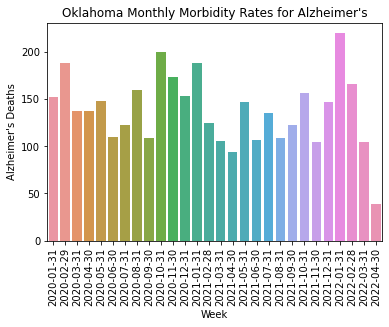

In [171]:
# Set up and plot bar graph for Oklahoma
oklahoma = alz_df.loc[alz_df.Code == 'OK']
oklahoma_month = oklahoma.resample(rule='M', on='week', convention='start')['alzheimer'].sum().reset_index()
oklahoma_month['week'] = oklahoma_month['week'].dt.date
ax = sns.barplot(x="week", y="alzheimer", data=oklahoma_month)

# Describe the graph
ax.set_title('Oklahoma Monthly Morbidity Rates for Alzheimer\'s')
ax.set_xlabel("Week")
ax.set_ylabel("Alzheimer\'s Deaths")
plt.xticks(rotation=90)

plt.show()

A final visualization of Mississippi, the state with the highest rates of Alzheimer's per capita indicates similar spikes in January 2022, but a different major increase in January of 2021. In general, Mississippi's rates appeared to remain higher throughout the last two years. Interestingly, a study by the Journal of Post-Acute and Long-term medicine (2020) indicates that the State of Mississippi also experienced nursing and medical staff shortages in the highest category bracket, between 19.9% and 50%. The shortages of staff may also play a part in the consistently high numbers. If this hypothesis is true, it indicates the importance of health workers' roles in not only providing physical care but also facilitating a source of connection for vulnerable older adults. 

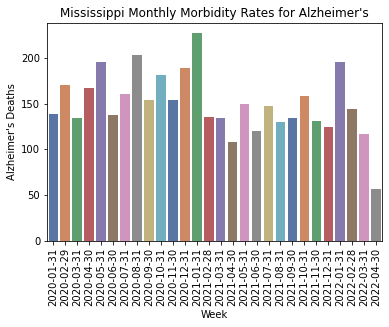

In [172]:
# Set up and plot bar graph for Mississippi
mississippi = alz_df.loc[alz_df.Code == 'MS']
ms_month = mississippi.resample(rule='M', on='week', convention='start')['alzheimer'].sum().reset_index()
ms_month['week'] = ms_month['week'].dt.date
ax = sns.barplot(x="week", y="alzheimer", data=ms_month, palette='deep')

# Describe the graph
ax.set_title('Mississippi Monthly Morbidity Rates for Alzheimer\'s')
ax.set_xlabel("Week")
ax.set_ylabel("Alzheimer\'s Deaths")
plt.xticks(rotation=90)

plt.show()

## Conclusion
In conclusion, it appears that the rise in cases did correlate with an increase in Alzheimer's deaths. As we move away from the most critical part of the pandemic, we are now able to step back and examine the true effects that the virus caused on both a physical and emotional level. 